In [1]:
!python --version


Python 3.12.7


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas.plotting as pd_plt
import matplotlib.colors as plt_colors
import sklearn

from sklearn.linear_model import RANSACRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler,KBinsDiscretizer, PolynomialFeatures, OrdinalEncoder,LabelEncoder, OneHotEncoder, TargetEncoder, RobustScaler, Normalizer, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, FixedThresholdClassifier, RepeatedKFold, GridSearchCV, KFold, StratifiedShuffleSplit, RepeatedStratifiedKFold, TunedThresholdClassifierCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.impute import SimpleImputer, KNNImputer
import category_encoders as ce
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor


from IPython.display import display
import time
import warnings
warnings.filterwarnings("ignore")



print('sklearn:', sklearn.__version__)
print("pandas:", pd.__version__)

sklearn: 1.5.1
pandas: 2.2.2


In [6]:
path_train = pd.read_csv('train.csv')

#### Описание датасета

Carat: вес (измеряется в каратах, что составляет 0,2 г) <br>
Cut: качество огранки (в порядке возрастания: Справедливая, Хорошая, Очень хорошая, Премиум, Идеальная) <br>
Color: цвет бриллианта (в порядке возрастания: J, I, H, G, F, E, D), где D является лучшим, а J - худшим.  
Clarity: показатель чистоты алмаза (I1 (наихудший), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (наилучший)).  
Depth: рассчитывается как высота бриллианта, измеренная от огранки до поверхности стола, деленная на его средний диаметр по окружности (на рисунке ниже    приведены интерпретации всех терминов, относящихся к алмазам).  
Table: размер бриллианта в таблице, выраженный в процентах от его диаметра.  
Price: стоимость бриллианта. Это значение, которое мы хотим предсказать, используя модели, которые будут приведены ниже.  
X: длина бриллианта в мм.  
Y: ширина бриллианта в мм.  
Z: глубина углубления в мм.  

#### изучение и предобработка данных 
1) решить проблему с данными, которые выбиваются из общей тенднеции. например, мы видим, что max по y это 58.9, что выглядит нереалистично.  Вероятно
нужна функция, находящая подобные строчки
2) необходимо добавить полиноминальные фичи (объем камня: x*y*z) тут есть мысль убрать отдельно    x,y,z и оставить только объем, например
3) нужно применить бининг по каратам.
4) применить к категориальным фичам encoding при этом думаю, стоит обратить внимание на качество камня и сделать иерархию правильную.
5) пропущенные данные: замена 0 на np.nan -> заполнение пропусков с помощью KNN 
   

## 1. EDA анализ. занимает бОльшую часть работы, т.к. чтобы предсказатть цену, нужно понять, как она образуется и выявить зависимости для написания наиболее оптимальной модели, которая еще и переобучаться не будет (хотелось бы)

In [7]:
path_train.describe()

,carat,depth,table,price,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.00000
mean,0.797227,61.746219,57.451551,3938.457274,5.728667,5.732720,3.53753
std,0.474440,1.420742,2.230915,3998.851904,1.123597,1.153284,0.70956
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.00000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.91000
50%,0.700000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.53000
75%,1.040000,62.500000,59.000000,5324.500000,6.540000,6.530000,4.03000
max,5.010000,78.200000,95.000000,18818.000000,10.740000,58.900000,31.80000


1) проверка на пропуски 

In [8]:
null_data = path_train[path_train.isnull().any(axis=1)]

In [9]:
null_data

,carat,cut,color,clarity,depth,table,price,x,y,z


видим присутствие нулевых значений: все они содержатся в x,y,z. Для начала заменим их на NA. (можно заполнить пропуски методом ближайших соседей!)

In [10]:
filtered_data = path_train[(path_train == 0).any(axis=1)]

In [11]:
filtered_data

,carat,cut,color,clarity,depth,table,price,x,y,z
4817,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
7928,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10418,2.02,Premium,H,VS2,62.7,53.0,18207,8.02,7.95,0.0
11203,2.25,Premium,I,SI1,61.3,58.0,15397,8.52,8.42,0.0
13661,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
15977,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.0
18359,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
19021,0.71,Good,F,SI2,64.1,60.0,2130,0.00,0.00,0.0
23017,1.20,Premium,D,VVS1,62.1,59.0,15686,0.00,0.00,0.0
25662,1.56,Ideal,G,VS2,62.2,54.0,12800,0.00,0.00,0.0


In [12]:
path_train.replace(0, np.nan, inplace=True)

In [13]:
path_train[path_train.isnull().any(axis=1)]


,carat,cut,color,clarity,depth,table,price,x,y,z
4817,1.07,Ideal,F,SI2,61.6,56.0,4954,NaN,6.62,NaN
7928,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,NaN
10418,2.02,Premium,H,VS2,62.7,53.0,18207,8.02,7.95,NaN
11203,2.25,Premium,I,SI1,61.3,58.0,15397,8.52,8.42,NaN
13661,1.14,Fair,G,VS1,57.5,67.0,6381,NaN,NaN,NaN
15977,0.71,Good,F,SI2,64.1,60.0,2130,NaN,NaN,NaN
18359,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,NaN
19021,0.71,Good,F,SI2,64.1,60.0,2130,NaN,NaN,NaN
23017,1.20,Premium,D,VVS1,62.1,59.0,15686,NaN,NaN,NaN
25662,1.56,Ideal,G,VS2,62.2,54.0,12800,NaN,NaN,NaN


2) проверка на дубликаты 

In [14]:
path_train[path_train.duplicated()]

,carat,cut,color,clarity,depth,table,price,x,y,z
868,1.00,Premium,F,VVS2,60.6,54.0,8924,6.56,6.52,3.96
11686,1.04,Premium,I,SI2,62.0,57.0,3774,6.53,6.47,4.03
12173,0.40,Premium,H,VS1,62.6,58.0,1035,4.71,4.68,2.94
12558,0.32,Ideal,E,VVS2,62.3,56.0,1080,4.40,4.37,2.73
13050,0.40,Premium,F,VS1,61.4,58.0,1050,4.75,4.73,2.91
...,...,...,...,...,...,...,...,...,...,...
39790,0.40,Premium,F,SI1,62.5,59.0,737,4.67,4.71,2.93
40006,0.30,Ideal,G,VS2,63.0,55.0,675,4.31,4.29,2.71
40181,1.21,Premium,H,SI2,61.9,55.0,5218,6.84,6.79,4.22
40388,1.52,Good,E,I1,57.3,58.0,3105,7.53,7.42,4.28


In [15]:
path_train.duplicated().sum()

78

In [16]:
path_train.drop_duplicates(inplace=True)

In [17]:
path_train.describe()

,carat,depth,table,price,x,y,z
count,40377.00000,40377.000000,40377.000000,40377.000000,40370.000000,40371.000000,40364.000000
mean,0.79713,61.745600,57.452126,3938.759690,5.729770,5.733738,3.538722
std,0.47404,1.420043,2.231121,3998.041468,1.120248,1.150464,0.706293
min,0.20000,43.000000,43.000000,326.000000,3.730000,3.710000,1.070000
25%,0.40000,61.000000,56.000000,946.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.000000,6.540000,6.530000,4.030000
max,5.01000,78.200000,95.000000,18818.000000,10.740000,58.900000,31.800000


3) каратная цикличность

(0.0, 3.0)

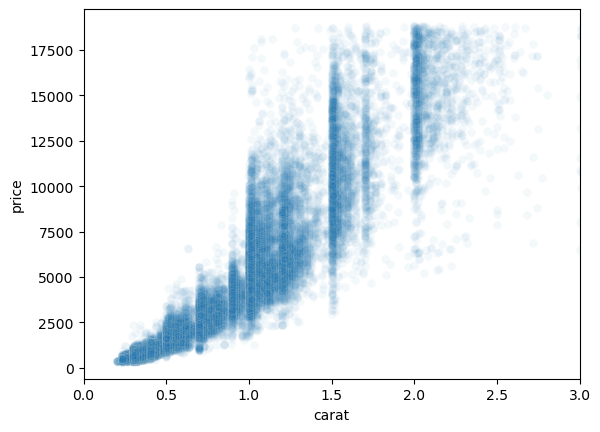

In [18]:
sns.scatterplot(data = path_train, x = 'carat', y = 'price', alpha=0.05);
plt.xlim(0,3)

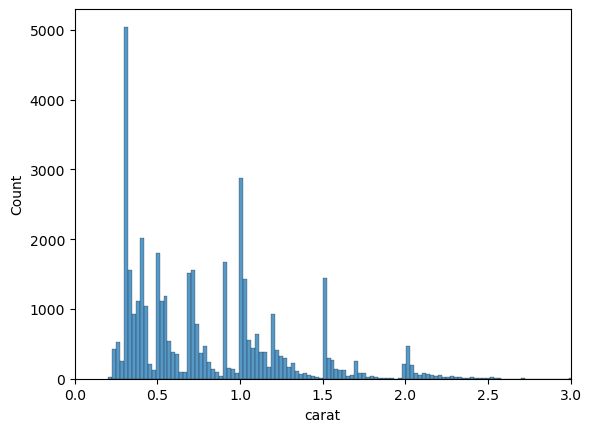

In [19]:
sns.histplot(data=path_train, x="carat", bins=200);
plt.xlim(0,3);

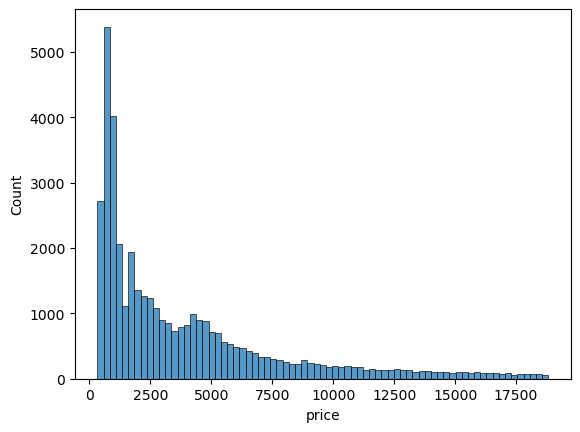

In [20]:
sns.histplot(path_train['price']);

тут интересный момент. у цены низкая корреляция с глубиной. Необходимо проверить гипотезу: при удалении столбца с глубиной качество модели будет улучшаться. На данный момент глубину действительно решила убрать

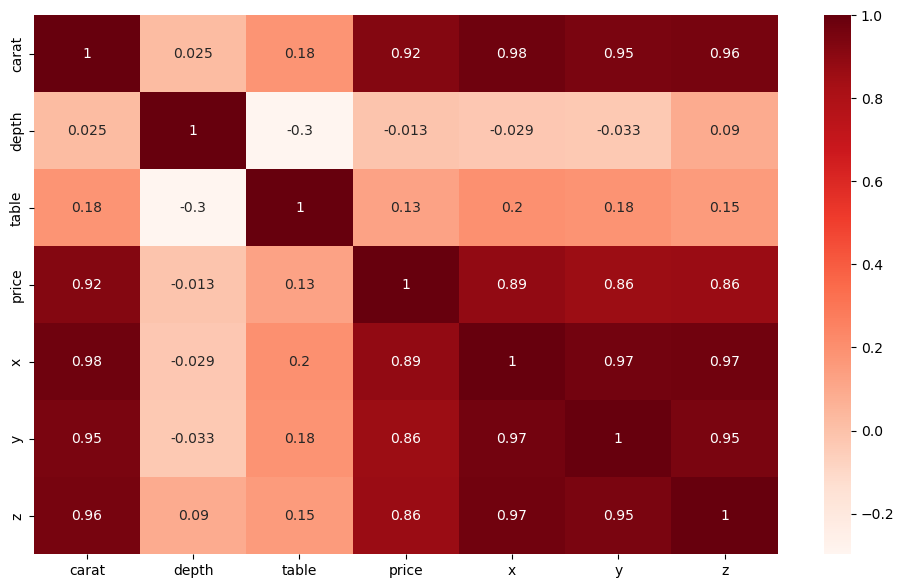

In [21]:
plt.figure(figsize=(12,7))
sns.heatmap(path_train.drop(['clarity', 'cut', 'color'], axis=1).corr(),annot=True,cmap='Reds')
plt.show()

Проведем анализ выбросов. примечательные значения: Y = 58 и Z около 30, всё остальное укладывается в реальные данные.   
бриллиантов большого размера действительно меньше, чем остальных, но их важно сохранить для того, чтобы модель предсказывала  
и большие цены для больших камней тоже.    


In [22]:

# Вычисляем квартиль 1 (Q1) и квартиль 3 (Q3)
Q1 = path_train['y'].quantile(0.25)
Q3 = path_train['y'].quantile(0.75)

# Вычисляем межквартильный диапазон (IQR)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим выбросы
outliers = path_train[(path_train['y'] < lower_bound) | (path_train['y'] > upper_bound)]

print("Выбросы по y:")
print(outliers)


Выбросы по y:
       carat        cut color clarity  depth  table  price      x      y     z
172     3.40       Fair     D      I1   66.8   52.0  15964   9.42   9.34  6.27
1195    3.04    Premium     I     SI2   59.3   60.0  18559   9.51   9.46  5.62
2455    0.51      Ideal     E     VS1   61.8   55.0   2075   5.15  31.80  5.12
5263    3.50      Ideal     H      I1   62.8   57.0  12587   9.65   9.59  6.03
5671    4.13       Fair     H      I1   64.8   61.0  17329  10.00   9.85  6.43
11354   3.01       Good     H     SI2   57.6   64.0  18593   9.44   9.38  5.42
11451   3.01       Fair     H      I1   56.1   62.0  10761   9.54   9.38  5.31
12241   3.24    Premium     H      I1   62.1   58.0  12300   9.44   9.40  5.85
12443   4.01    Premium     I      I1   61.0   61.0  15223  10.14  10.10  6.17
16230   2.00    Premium     H     SI2   58.9   57.0  12210   8.09  58.90  8.06
16718   4.50       Fair     J      I1   65.8   58.0  18531  10.23  10.16  6.72
17484   3.00    Premium     G      I1 

In [23]:
# Вычисляем квартиль 1 (Q1) и квартиль 3 (Q3)
Q1 = path_train['x'].quantile(0.25)
Q3 = path_train['x'].quantile(0.75)

# Вычисляем межквартильный диапазон (IQR)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим выбросы
outliers = path_train[(path_train['x'] < lower_bound) | (path_train['x'] > upper_bound)]

print("Выбросы по x:")
print(outliers)

Выбросы по x:
       carat        cut color clarity  depth  table  price      x      y     z
172     3.40       Fair     D      I1   66.8   52.0  15964   9.42   9.34  6.27
1195    3.04    Premium     I     SI2   59.3   60.0  18559   9.51   9.46  5.62
2142    3.01    Premium     J     SI2   60.7   59.0  18710   9.35   9.22  5.64
5263    3.50      Ideal     H      I1   62.8   57.0  12587   9.65   9.59  6.03
5671    4.13       Fair     H      I1   64.8   61.0  17329  10.00   9.85  6.43
11354   3.01       Good     H     SI2   57.6   64.0  18593   9.44   9.38  5.42
11451   3.01       Fair     H      I1   56.1   62.0  10761   9.54   9.38  5.31
12241   3.24    Premium     H      I1   62.1   58.0  12300   9.44   9.40  5.85
12443   4.01    Premium     I      I1   61.0   61.0  15223  10.14  10.10  6.17
16718   4.50       Fair     J      I1   65.8   58.0  18531  10.23  10.16  6.72
17484   3.00    Premium     G      I1   59.7   60.0  13203   9.42   9.26  5.58
19395   3.00       Good     I      I1 

In [24]:
# Вычисляем квартиль 1 (Q1) и квартиль 3 (Q3)
Q1 = path_train['z'].quantile(0.25)
Q3 = path_train['z'].quantile(0.75)

# Вычисляем межквартильный диапазон (IQR)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим выбросы
outliers = path_train[(path_train['z'] < lower_bound) | (path_train['z'] > upper_bound)]

print("Выбросы по z:")
print(outliers)

Выбросы по z:
       carat        cut color clarity  depth  table  price      x      y  \
172     3.40       Fair     D      I1   66.8   52.0  15964   9.42   9.34   
1895    0.51  Very Good     E     VS1   61.8   54.7   1970   5.12   5.15   
2375    3.00       Fair     I     SI2   64.8   59.0  16970   8.93   8.73   
4723    3.01    Premium     F      I1   62.2   56.0   9925   9.24   9.13   
5043    3.01       Fair     I     SI2   65.8   56.0  18242   8.99   8.94   
5263    3.50      Ideal     H      I1   62.8   57.0  12587   9.65   9.59   
5671    4.13       Fair     H      I1   64.8   61.0  17329  10.00   9.85   
8446    2.01       Fair     G     SI2   65.6   56.0  15562   7.89   7.84   
10860   3.11       Fair     J      I1   65.9   57.0   9823   9.15   9.02   
12241   3.24    Premium     H      I1   62.1   58.0  12300   9.44   9.40   
12443   4.01    Premium     I      I1   61.0   61.0  15223  10.14  10.10   
16197   3.01      Ideal     J      I1   65.4   60.0  16538   8.99   8.93  

подозрительный выброс по y (58) и z(31) заменила на медианное значение

In [25]:
median_value = path_train['y'].median()
path_train.loc[path_train['y'] > 50, 'y'] = median_value


In [26]:
median_value = path_train['z'].median()
path_train.loc[path_train['z'] > 28, 'z'] = median_value

In [ ]:
path_train.describe()

видим, что идеальная огранка встречается у экземпляров с небольшим каратом и чем больше размер, тем больше огранки уровня премиум

In [ ]:
sns.scatterplot(path_train, x = 'carat', y = 'price', hue='cut', alpha = 0.3)
plt.title("Зависимость стоимости от веса(карата) и качества огранки");

видим переход цветов в зависимости от размера камня. значит определенным каратам соотносятся определенные цвета

In [ ]:
sns.scatterplot(path_train, x = 'carat', y = 'price', hue='color', alpha = 0.3)
plt.title("Зависимость стоимости от веса (карата) и цвета");

мы видим, что цена растет линейно для I1 и квадратично для остального clarity. поэтому мы учтем это в map для clarity ниже

In [ ]:
sns.relplot(data = path_train, x = 'carat', y = 'price', col = 'clarity', kind = 'scatter');

ещё немного визуализации, потому что я люблю графики :)

In [ ]:
# Выбираем числовые столбцы и исключаем 'price'
int_cols = path_train.select_dtypes(exclude='object').columns.to_list()
int_cols.remove('price')


fig = plt.figure(figsize=(15, 10), constrained_layout=True)
plt.suptitle("Регрессия числовых переменных", size=20, weight='bold')

for j, i in enumerate(int_cols):
    ax = plt.subplot(3, 3, j + 1) 
    sns.regplot(data=path_train, x=i, y='price', ax=ax, color='pink', line_kws={'color': 'purple'})
    ax.set_title("Анализ сравнения цены и {}".format(i), family='sans-serif')  

    # Скрываем границы графиков для более чистого вида
    

plt.show()


In [ ]:
# Находим числовые столбцы
int_cols = path_train.select_dtypes(exclude='object').columns.to_list()
j = 0

# Создаем фигуру
fig = plt.figure(figsize=(15, 10), constrained_layout=True)
plt.suptitle("Распределение числовых переменных", family='sans-serif', size=20, weight='bold')

# Проходим по каждому числовому столбцу
for i in int_cols:
    ax = plt.subplot(3, 3, j + 1)  # Создаем подграфик
    sns.kdeplot(data=path_train, x=i, color='pink', fill=True, edgecolor='purple', alpha=1)
    ax.set_title("Распределение числовых переменных - {}".format(i), family='sans-serif')

    # Скрываем границы графиков для более чистого вида
    for s in ['left', 'right', 'top', 'bottom']:
        ax.spines[s].set_visible(False)
    
    j += 1  # Увеличиваем индекс для следующего подграфика

plt.show() 

'Очевидно, что в данных есть выбросы. Нам нужно проверить их, чтобы определить, являются ли они экстремальными значениями или ошибками в данных.'

In [ ]:
j = 0
fig = plt.figure(figsize=(15, 10))
plt.suptitle("Боксплот для числовых переменных", family='sans-serif', size=20, weight='bold')  


for i in int_cols:
    ax = plt.subplot(3, 3, j + 1)  
    sns.boxplot(data=path_train, x=i, color='purple') 
    ax.set_title("Боксплот для {}".format(i))

 
    j += 1  
plt.show()  

In [ ]:

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
plt.suptitle("Сравнение категориальных признаков с ценой", family='sans-serif', size=20, weight='bold')


cat_cols = path_train.select_dtypes(include='object').columns.to_list()


ax = fig.subplot_mosaic("""
                        AAB
                        AAC
                        AAD
                        """)

# Строим график плотности для переменной 'price'
sns.kdeplot(path_train['price'], fill=True, edgecolor='purple', linewidth=2, color='purple', ax=ax['A'], alpha=0.8)
ax['A'].text(x=2000, y=0.00025, s="Целевая переменная цена не имеет нормального распределения", family='sans-serif', fontweight='bold')
ax['A'].text(x=2000, y=0.00023, s="Сравнивая цену с категориальными признаками, можем видеть, что медиана более-менее одинакова", family='sans-serif', fontweight='bold')

# Строим боксплоты для категориальных признаков
sns.boxplot(data=path_train, x=cat_cols[0], y='price', ax=ax['B'], color='pink')  
sns.boxplot(data=path_train, x=cat_cols[1], y='price', ax=ax['C'], color='pink')  
sns.boxplot(data=path_train, x=cat_cols[2], y='price', ax=ax['D'], color='pink') 



plt.show()  

#### Проверяю гипотезу о том, что стоит убрать выбросы. 
пришла к выводу, что выбросы стоит оставлять, т.к. в данном датасете к выбросам относятся уникальные дорогие камни и нам важно их научиться предсказывать.


In [ ]:
#import scipy.stats as st

В Python оператор ~ используется для выполнения побитового отрицания (NOT). В контексте маскирования в pandas он инвертирует логические значения.
Эта строка создает маску, которая возвращает True для строк, не являющихся выбросами, и False для строк, которые являются выбросами.

In [ ]:
#numeric_cols = path_train.select_dtypes(include=['number'])

# Шаг 2: Вычисление квартилей и IQR
#Q1 = numeric_cols.quantile(0.25)
#Q3 = numeric_cols.quantile(0.75)
#IQR = Q3 - Q1

# Шаг 3: Фильтрация выбросов
# Создаем маску для фильтрации выбросов
#mask = ~((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR)))

# Удаляем строки, содержащие хотя бы один выброс
#path_train = path_train[mask.all(axis=1)]

# path_train_filtered теперь содержит данные без выбросов

In [ ]:
# Feature engineering
def add_features(path_train):
    path_train['volume'] = path_train['x'] * path_train['y'] * path_train['z']
    path_train['density'] = path_train['carat'] / path_train['volume']
    path_train['table_ratio'] = (path_train['table'] / ((path_train['x'] + path_train['y']) / 2))
    path_train['depth_ratio'] = (path_train['depth'] / ((path_train['x'] + path_train['y']) / 2))
    path_train['symmetry'] = (abs(path_train['x'] - path_train['z']) + abs(path_train['y'] - path_train['z'])) / (path_train['x'] + path_train['y'] + path_train['z'])
    path_train['surface_area'] = 2 * ((path_train['x'] * path_train['y']) + (path_train['x'] * path_train['z']) + (path_train['y'] * path_train['z']))
    path_train['depth_to_table_ratio'] = path_train['depth'] / path_train['table']
    path_train['depth_per_volume'] = path_train['depth'] / (path_train['volume'] + 1e-6)
    path_train['depth_per_density'] = path_train['depth'] / (path_train['density'] + 1e-6)
    path_train['depth_per_table'] = path_train['depth'] / (path_train['table'] + 1e-6)
    return path_train


In [ ]:
new_features = ['volume','density','table_ratio','depth_ratio','symmetry','surface_area','depth_to_table_ratio','depth_per_volume','depth_per_density', 'depth_per_table']

In [ ]:
#path_train = add_features(path_train)

In [ ]:
path_train

я решила преобразовать table на основании официальной статистики о камнях, но это вероятно излишний регрессор. поэтому пока убираем его

In [ ]:
def diamond_shape(path_train):
    dshape = []
    for i in path_train['table'].index:
        if 54<path_train['table'][i]<57 and 61<path_train['depth'][i]<62.5:
            dshape.append('round')
        elif 52<path_train['table'][i]<60 and 60<path_train['depth'][i]<68:
            dshape.append('oval')
        elif 63<path_train['table'][i]<69 and 69<path_train['depth'][i]<76:
            dshape.append('princess')
        elif 58<path_train['table'][i]<63 and 58<path_train['depth'][i]<66:
            dshape.append('cushion')
        else:
            dshape.append('others')
    return dshape

In [ ]:
path_train['diamond_shape'] = diamond_shape(path_train)

## Работа с моделями машинного обучения

разобьем фичи на группы в зависимости от их характерных особенностей для дальнейшей их обработки

In [ ]:
axis_features = ['x','y','z']
numeric_features = ['carat']

In [ ]:
X = path_train.drop(['price'], axis=1)
y = path_train['price']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, shuffle = True) #shuffle - перемешиваем данные перед разделением
X_test.shape 

Clarity: показатель чистоты алмаза (I1 (наихудший), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (наилучший)).
я сопоставляю показателю чистоты номер в порядке убывания от наилучшего к наихудшему, что позволит применить OrdinalEncoder, т.к. показатель чистоты важен для модели и влияет на цену.

In [ ]:
path_train['clarity'].unique()

J, I, H, G, F, E, D

In [ ]:
display(path_train['color'].unique())
path_train['color'].nunique()

Справедливая, Хорошая, Очень хорошая, Премиум, Идеальная

In [ ]:
display(path_train['cut'].unique())
path_train['cut'].nunique()

In [ ]:
clarity_map = [{
    'col':'clarity',
    'mapping':{'IF':8**2,
               'VVS1':7**2,
               'VVS2':6**2,
               'VS1':5**2,
               'VS2':4**2,
               'SI1':3**2,
               'SI2':2**2,
               'I1':1
              }
    }]

In [ ]:
color_map = [{
    'col':'color',
    'mapping':{'D':7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 
               'J':1}
    }]

In [ ]:
cut_map = [{ 'col' : 'cut', 'mapping': {
                                     'Ideal' : 5,
                                     'Premium' : 4,
                                     'Very Good': 3,
                                     'Good' : 2,
                                      'Fair' : 1
}
           }]

In [ ]:
table_mup = [{'col' :'diamond_shape',  'mapping':  {'round':4, 'oval': 1, 'princess': 3, 'cushion':2, 'others':0}}]

In [ ]:
table_mup

In [ ]:
path_train

Robust Scaling (робастное масштабирование): применяется для данных с выбросами, которые могли остаться после очистки. Минимизирует влияние выбросов. Использует медиану и интерквартильный размах вместо среднего и стандартного отклонения.    
||||Параметр degree=2 позволяет создавать комбинации до второго порядка (включая произведения).  
interaction_only=True гарантирует, что будут добавлены только взаимодействия (т.е. произведения) между признаками, а не полиномиальные степени.

In [ ]:
transformer_axis = Pipeline(steps=[
    ('imputer',KNNImputer(missing_values=np.nan, add_indicator=False, n_neighbors = 4, weights = "uniform")),
    ('scaler', RobustScaler()),
    ('polynomial', PolynomialFeatures(degree=3,include_bias=False, interaction_only=True))
])

transformer_numeric = Pipeline(steps=[
    ('binner', KBinsDiscretizer(n_bins = 20, strategy='quantile', encode='onehot-dense')),
    ('polynominal', PolynomialFeatures(degree=2,include_bias=False, interaction_only=False)),
    ('scaler', RobustScaler())])

transformer_new_features = Pipeline(steps=[
    ('imputer',KNNImputer(missing_values=np.nan, add_indicator=False)),
    ('scaler', StandardScaler()),
])

#обработка категориальных фич. очень важно в данном случае соблюдать иерархию присвоения номеров,
#т.к. наилучшие по цвету, огранке и чистоте будут стоить дороже.
transformer_clarity = Pipeline(steps=[
    ('encoder',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', StandardScaler()),
    ])

transformer_color = Pipeline(steps = [
    ('encoder',ce.OrdinalEncoder(mapping = color_map)),
    ('scaler', RobustScaler())
    ])
transformer_cut = Pipeline( steps = [
      ('encoder',ce.OrdinalEncoder(mapping = cut_map)),
    ('scaler', StandardScaler())
    ])
transformer_table_new = Pipeline ( steps = [
    ('encoder', ce.OrdinalEncoder(mapping = table_mup)),
    ('scaler', StandardScaler())
])
transformer_table = Pipeline( steps = [
    ('scaler', StandardScaler())
    ])
#------------------------------------------------------------------------------------------------------------------------------------------------------
CT = ColumnTransformer([
       ("pol_axis", transformer_axis, axis_features),
        ("numeric", transformer_numeric, numeric_features),
        ("clarity", transformer_clarity, ['clarity']),
        ('color', transformer_color, ['color']),
        ('cut', transformer_cut, ['cut']),
       # ('table', transformer_table, ['table'])
       # ('new', transformer_new_features, new_features)
      #  ('table', transformer_table_new, ['diamond_shape']),
        
])

In [ ]:
display(CT)

ct = CT.fit_transform(X_train)
pd.DataFrame(ct).head().T

#### переходим к моделям 

1. KNN для регрессии
   

In [ ]:
def irq_mse(y_true, y_pred):
    delta = y_pred-y_true
    Q25 = np.quantile(delta, 0.25)
    Q75 = np.quantile(delta, 0.75)
    irq = Q75-Q25
    mask = (delta<(Q25-1.5*irq)) | (delta> (Q75+1.5*irq))
    if (mask.sum()==0):
        rez=0
    else: rez = -sum((delta[mask])**2) / mask.sum()
    return rez

In [ ]:
scoring_mse_irq = make_scorer(irq_mse, greater_is_better=True)

In [ ]:
from sklearn.model_selection import StratifiedKFold


In [ ]:
start = time.time()

pipe = Pipeline([
    ('preprocessing', CT),
    ('knn', KNeighborsRegressor())
])

# Настройка кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Параметры для сеточного поиска
param_grid = {
    'knn__n_neighbors': [5, 7, 9,20,30,40,60],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Настройка GridSearchCV
grid = GridSearchCV(pipe, param_grid, scoring = scoring_mse_irq, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

# Получение результатов
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score", 'std_test_score']).T

# Вывод результатов
print(grid_result)

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

In [ ]:
grid.best_score_

In [ ]:
best_params = grid.best_params_
best_params

In [ ]:
KNN_REG = Pipeline([
    ('preprocessing', CT),
    ('knn', KNeighborsRegressor(metric='manhattan', n_neighbors=7, weights='distance'))
])


In [ ]:

KNN_REG = Pipeline([
    ('preprocessing', CT),
    ('yeo-johnson', PowerTransformer(method='yeo-johnson')),  
    ('knn', KNeighborsRegressor(metric='manhattan', n_neighbors=7, weights='distance'))
])

In [ ]:
cross_vall = cross_val_score(KNN_REG, X_train, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=10), scoring='neg_mean_squared_error')


In [ ]:
np.mean(cross_vall)

In [ ]:
KNN_REG.fit(X_train,y_train)

In [ ]:
KNN_REG_pred = KNN_REG.predict(X_test)
KNN_REG.score(X_train, y_train)

In [ ]:
mean_squared_error(y_test, KNN_REG_pred)

In [ ]:
mean_absolute_percentage_error(y_test, KNN_REG_pred)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, KNN_REG_pred))

print("RMSE:", rmse)

проверим, насколько ошибка гетероскедастична. в целом, ситуация хорошая, ошибки сконцентированы в районе нуля + когда я в полином фичах добавила помимо объема ещё каждую фичу в квадрате, то стало еще кучнее к нулю.

In [ ]:
residuals = y_test - KNN_REG_pred

plt.scatter(KNN_REG_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# График истинных значений
plt.scatter(X_test['carat'], y_test, color='blue', label='Истинные значения', alpha=0.6)

# График предсказанных значений
plt.scatter(X_test['carat'], KNN_REG_pred, color='red', label='Предсказанные значения', alpha=0.6)

# Настройка графика
plt.title('Сравнение истинных и предсказанных значений')
plt.xlabel('X_test')
plt.ylabel('Значения')
plt.legend()
plt.grid()

# Показать график
plt.show()

In [ ]:
def irq_mse(y_true, y_predict):
    delta = y_predict-y_true
    Q25 = np.quantile(delta, 0.25)
    Q75 = np.quantile(delta, 0.75)
    irq = Q75-Q25
    mask = (delta<(Q25-1.5*irq)) | (delta> (Q75+1.5*irq))
    if (mask.sum()==0):
        rez=0
    else: rez = -sum((delta[mask])**2) / mask.sum()
    return rez

In [ ]:
irq_mse(y_test, KNN_REG_pred)

#### LinearSVR

In [ ]:
start = time.time()

pipe = Pipeline(steps=[
    ('preprocessor', CT),
    ('svr', LinearSVR())
])

# Определение параметров для подбора
param_grid = {
    'svr__C': [0.01,0.1, 0.5, 1, 10, 100],  # Параметр регуляризации
    'svr__epsilon': [0.01, 0.1, 0.5],# Параметр epsilon для контроля ошибки
    'svr__max_iter': [500, 1000, 2000, 5000],
    'svr__tol': [1e-4, 1e-3]
}
# Настройка кросс-валидации
cv = RepeatedKFold(n_splits=5, n_repeats=10)

# Настройка GridSearchCV
grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, return_train_score=True)

# Обучение модели
grid.fit(X_train, y_train)

# Вывод наилучших параметров и результата
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", -grid.best_score_)

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

In [ ]:
LinearSVR_pipeline = Pipeline([
    ('preprocessing', CT),
    ('LinearSVR', LinearSVR(C=10, epsilon=0.5, loss='epsilon_insensitive', max_iter = 500, tol = 0.001))  
])

In [ ]:

LinearSVR_pipeline = TransformedTargetRegressor( 
    Pipeline([
    ('preprocessing', CT),
    ('LinearSVR', LinearSVR(C=10, epsilon=0.5, loss='epsilon_insensitive', max_iter = 500, tol = 0.001))  
]),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution='normal')
)
    

In [ ]:
# Логарифмирование с добавлением 1, чтобы избежать проблем с нулями
def log_transform(x):
    return np.log(x + 1)

# Обратное преобразование (экспоненциальное), с вычитанием 1
def inv_log_transform(x):
    return np.exp(x) - 1

# Логарифмическое преобразование
log_transformer = FunctionTransformer(log_transform, inverse_func=inv_log_transform)

# Преобразование Box-Cox, применяется только к положительным данным
boxcox_transformer = PowerTransformer(method='yeo-johnson')

# Трансформатор для целей регрессии с обратным преобразованием
LinearSVR_pipeline = TransformedTargetRegressor(
    regressor=Pipeline([
        ('preprocessing', CT),  # Ваши этапы предварительной обработки данных, например, Scaling или Encoding
        ('LinearSVR', LinearSVR(C=10, epsilon=0.5, loss='epsilon_insensitive', max_iter=500, tol=0.001))
    ]),
    transformer=Pipeline([
          # Логарифмирование целевой переменной
        ('boxcox', boxcox_transformer)  # Применение Box-Cox для стабилизации дисперсии
    ])
)

In [ ]:
LinearSVR_pipeline.fit(X_train,y_train)

In [ ]:
LinearSVR_pred = LinearSVR_pipeline.predict(X_test)


In [ ]:
LinearSVR_pred  = boxcox_transformer.inverse_transform(LinearSVR_pred.reshape(-1, 1)) 


In [ ]:
LinearSVR_pipeline.score(X_train, y_train)

In [ ]:
mean_absolute_percentage_error(y_test, LinearSVR_pred)

In [ ]:
mean_squared_error(y_test, LinearSVR_pred)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, LinearSVR_pred))

print("RMSE:", rmse)

проверим, насколько ошибка гетероскедастична. тенденция весьма печальная. 

In [ ]:
residuals = y_test - LinearSVR_pred

plt.scatter(LinearSVR_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

In [ ]:
irq_mse(y_test, LinearSVR_pred)

#### RIDGE-регрессия

In [ ]:
start = time.time()

pipe = Pipeline(steps=[
    ('preprocessing', CT),
    ('ridge', Ridge())
])

# Определение параметров для подбора
param_grid = {
    'ridge__alpha': [0.1, 1, 10, 100]  # Параметр регуляризации
}

# Настройка GridSearchCV
grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
grid.fit(X_train, y_train)

# Вывод наилучших параметров и результата
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", -grid.best_score_)

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

In [ ]:
Ridge_pipeline = Pipeline([
    ('preprocessing', CT),
    ('Ridge', Ridge(alpha = 1
                   ))  
])

In [ ]:
Ridge_pipeline.fit(X_train,y_train)

In [ ]:
Ridge_pred = Ridge_pipeline.predict(X_test)
Ridge_pipeline.score(X_train, y_train)

In [ ]:
mean_absolute_percentage_error(y_test, Ridge_pred)

In [ ]:
mean_squared_error(y_test, Ridge_pred)


проверим, насколько ошибка гетероскедастична. тенденция весьма печальная.   
почему у нас вообще предсказанные значения ниже нуля?

In [ ]:
residuals = y_test - Ridge_pred

plt.scatter(Ridge_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# График истинных значений
plt.scatter(X_test['carat'], y_test, color='blue', label='Истинные значения', alpha=0.6)

# График предсказанных значений
plt.scatter(X_test['carat'], Ridge_pred, color='red', label='Предсказанные значения', alpha=0.6)

# Настройка графика
plt.title('Сравнение истинных и предсказанных значений')
plt.xlabel('X_test')
plt.ylabel('Значения')
plt.legend()
plt.grid()

# Показать график
plt.show()

LASSO - регрессия

In [ ]:
start = time.time()

pipe = Pipeline(steps=[
    ('preprocessing', CT),
    ('lasso', Lasso())
])

# Определение параметров для подбора
param_grid = {
    'lasso__alpha': [0.1, 1, 10, 100]  # Параметр регуляризации для Lasso
}

# Настройка GridSearchCV
grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
grid.fit(X_train, y_train)

# Вывод наилучших параметров и результата
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", -grid.best_score_)

print(f"Цикл пройден за {round((time.time() - start) / 60, 1)} минут")

In [ ]:
Lasso_pipeline = Pipeline([
    ('preprocessing', CT),
    ('lasso', Lasso(alpha = 0.1
                   ))  
])

In [ ]:
Lasso_pipeline.fit(X_train,y_train)

In [ ]:
Lasso_pred = Lasso_pipeline.predict(X_test)
Lasso_pipeline.score(X_train, y_train)

In [ ]:
mean_absolute_percentage_error(y_test, Lasso_pred)

In [ ]:
plt.figure(figsize=(10, 6))

# График истинных значений
plt.scatter(X_test['carat'], y_test, color='blue', label='Истинные значения', alpha=0.6)

# График предсказанных значений
plt.scatter(X_test['carat'], Lasso_pred, color='red', label='Предсказанные значения', alpha=0.6)

# Настройка графика
plt.title('Сравнение истинных и предсказанных значений')
plt.xlabel('X_test')
plt.ylabel('Значения')
plt.legend()
plt.grid()

# Показать график
plt.show()

#### это какая-то шиза

In [ ]:
import shap

explainer_knn = shap.KernelExplainer(lambda x: KNN_REG.predict(x))

# Для простоты начнем с одного записи тестового набора данных 
shap_values_single_record = explainer_knn.shap_values(X_test.iloc[:1])

# Чтобы увидеть влияние всех записей тестового набора данных одновременно,
  # нам нужно увеличить количество образцов (samples):
  
nsamples = len(y_test)
shap_values_all_records = explainer_knn.shap_values(X_test.head(nsamples))
 
  # Альтернатива: если вы предпочитаете использовать только среднее значение медианы тренировочного набора данных,
    # вы можете использовать следующий вариант:
    
med_X_train = X_train.median(axis=0).reshape(-1,len(X_train.columns))
explainer_median_based = shap.KernelExplainer(lambda x: KNN_REG.predict(med_X_train))
shap_values_median_based = explainer_median_based.shap_values(X_test.head())
     
  # Однако для простого понимания лучше использовать все точки тестового набора данных.
      
  ### Шаг 3: Генерация графика суммарных значений SHAP

    
shap.summary_plot(shap_values_all_records,y_test.head()) 
    
    # Этот граф покажет относительное влияние каждого признака на целевую переменную за весь тестовый набор данных.
        